In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression

from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import classification_report
from pylab import rcParams
from sklearn.preprocessing import scale 

%matplotlib inline
plt.style.use('seaborn-white')

In [4]:
import json
with open("df_1hour_Feb.json", 'r', encoding='UTF-8') as f:
    F_data = json.load(f)

In [5]:
with open("df_1hour_Mar_05.json", 'r', encoding='UTF-8') as f:
    M_data = json.load(f)

In [6]:
COLUMNS = ['name', 'code', 'time', 'price', 'time_1', 'price_1', 'price_dif_1', 'sell_1', 'buy_1', 'volume_1', 'variation_1', 'post_num_1', 'unique_id_1', 'click_1', 'like_1', 'dislike_1', 'time_2', 'price_2', 'price_dif_2', 'sell_2', 'buy_2', 'volume_2', 'variation_2', 'post_num_2', 'unique_id_2', 'click_2', 'like_2', 'dislike_2', 'time_3', 'price_3', 'price_dif_3', 'sell_3', 'buy_3', 'volume_3', 'variation_3', 'post_num_3', 'unique_id_3', 'click_3', 'like_3', 'dislike_3', 'mkt_cap', 'kospi', 'kosdaq', 'trash', 'yesterday_closing_price', 'is_maximum', 'is_minimum', 'price_volatility', 'price_trend', 'average_price_volatility', 'sell_minus_buy_1', 'sell_minus_buy_2', 'sell_minus_buy_3', 'is_price_gap_stable', 'price_gap_volatility', 'is_like_higher', 'volume_trend', 'post_num_trend', 'unique_id_trend', 'click_trend', 'price_increase', 'did_price_increase', 'did_price_033', 'did_price_100', 'did_price_150', 'kospi_ind', 'kosdaq_ind', 'time_slot', 'ko_inter', 'early_mor', 'morning', 'lunch', 'afternoon', 'late', 'mkt_change', 'alpha', 'per_now', 'kospi_1', 'kospi_2', 'kospi_3', 'kospi_answer', 'kosdaq_1', 'kosdaq_2', 'kosdaq_3', 'kosdaq_answer', 'kospi_trend', 'kosdaq_trend', 'kospi_increase', 'kosdaq_increase', 'market_increase', 'did_opening_price_increase', 'price_1_sq', 'price_dif_1_sq', 'sell_1_sq', 'buy_1_sq', 'volume_1_sq', 'variation_1_sq', 'post_num_1_sq', 'unique_id_1_sq', 'click_1_sq', 'like_1_sq', 'dislike_1_sq', 'price_2_sq', 'price_dif_2_sq', 'sell_2_sq', 'buy_2_sq', 'volume_2_sq', 'variation_2_sq', 'post_num_2_sq', 'unique_id_2_sq', 'click_2_sq', 'like_2_sq', 'dislike_2_sq', 'price_3_sq', 'price_dif_3_sq', 'sell_3_sq', 'buy_3_sq', 'volume_3_sq', 'variation_3_sq', 'post_num_3_sq', 'unique_id_3_sq', 'click_3_sq', 'like_3_sq', 'dislike_3_sq', 'mkt_cap_sq', 'yesterday_closing_price_sq', 'price_volatility_sq', 'price_trend_sq', 'average_price_volatility_sq', 'sell_minus_buy_1_sq', 'sell_minus_buy_2_sq', 'sell_minus_buy_3_sq', 'price_gap_volatility_sq', 'volume_trend_sq', 'post_num_trend_sq', 'unique_id_trend_sq', 'click_trend_sq', 'kospi_ind_sq', 'kosdaq_ind_sq', 'time_slot_sq', 'ko_inter_sq', 'mkt_change_sq', 'alpha_sq', 'per_now_sq', 'kospi_1_sq', 'kospi_2_sq', 'kospi_3_sq', 'kosdaq_1_sq', 'kosdaq_2_sq', 'kosdaq_3_sq', 'kospi_trend_sq', 'kosdaq_trend_sq']

In [7]:
df_F = pd.DataFrame(F_data, columns = COLUMNS)
df_M = pd.DataFrame(M_data, columns = COLUMNS)
df = pd.concat([df_F, df_M])

In [8]:
df = df.dropna(axis=0, how='any')

In [9]:
time_filter_train = (df['time'].str.startswith("2018-02-21")) | \
                    (df['time'].str.startswith("2018-02-20")) | \
                    (df['time'].str.startswith("2018-02-14")) | \
                    (df['time'].str.startswith("2018-02-22")) | \
                    (df['time'].str.startswith("2018-02-23")) | \
                    (df['time'].str.startswith("2018-02-26")) 

time_filter_test = (df['time'].str.startswith("2018-02-28")) | \
                   (df['time'].str.startswith("2018-03-02")) | \
                   (df['time'].str.startswith("2018-03-05")) | \
                   (df['time'].str.startswith("2018-02-27"))
        
train_df = df[time_filter_train].reset_index(drop = True)
test_df = df[time_filter_test].reset_index(drop = True)

In [10]:
X_COL = ['price_1','price_dif_1','sell_1','buy_1','volume_1','variation_1','post_num_1','unique_id_1','click_1',
     'like_1','dislike_1','price_2','price_dif_2','sell_2','buy_2','volume_2','variation_2','post_num_2','unique_id_2',
     'click_2','like_2','dislike_2','price_3','price_dif_3','sell_3','buy_3','volume_3','variation_3','post_num_3',
     'unique_id_3','click_3','like_3','dislike_3','mkt_cap','kospi','kosdaq','trash','yesterday_closing_price',
     'is_maximum','is_minimum','price_volatility','price_trend','average_price_volatility','sell_minus_buy_1',
     'sell_minus_buy_2','sell_minus_buy_3','is_price_gap_stable','price_gap_volatility','is_like_higher',
     'volume_trend','post_num_trend','unique_id_trend','click_trend','kospi_ind','kosdaq_ind','time_slot',
     'ko_inter','early_mor','morning','lunch','afternoon','late','mkt_change','alpha','per_now','kospi_1','kospi_2',
     'kospi_3','kosdaq_1','kosdaq_2','kosdaq_3','kospi_trend','kosdaq_trend','did_opening_price_increase',
     'price_1_sq','price_dif_1_sq','sell_1_sq','buy_1_sq','volume_1_sq','variation_1_sq','post_num_1_sq',
     'unique_id_1_sq','click_1_sq','like_1_sq','dislike_1_sq','price_2_sq','price_dif_2_sq','sell_2_sq',
     'buy_2_sq','volume_2_sq','variation_2_sq','post_num_2_sq','unique_id_2_sq','click_2_sq','like_2_sq',
     'dislike_2_sq','price_3_sq','price_dif_3_sq','sell_3_sq','buy_3_sq','volume_3_sq','variation_3_sq',
     'post_num_3_sq','unique_id_3_sq','click_3_sq','like_3_sq','dislike_3_sq','mkt_cap_sq',
     'yesterday_closing_price_sq','price_volatility_sq','price_trend_sq','average_price_volatility_sq',
     'sell_minus_buy_1_sq','sell_minus_buy_2_sq','sell_minus_buy_3_sq','price_gap_volatility_sq',
     'volume_trend_sq','post_num_trend_sq','unique_id_trend_sq','click_trend_sq','kospi_ind_sq','kosdaq_ind_sq',
     'time_slot_sq','ko_inter_sq','mkt_change_sq','alpha_sq','per_now_sq','kospi_1_sq','kospi_2_sq','kospi_3_sq',
     'kosdaq_1_sq','kosdaq_2_sq','kosdaq_3_sq','kospi_trend_sq','kosdaq_trend_sq']

In [11]:
X = df[X_COL]
y = df['did_price_033']
X_train = train_df[X_COL]
X_test = test_df[X_COL]
y_train = train_df['did_price_033']
y_test = test_df['did_price_033']
y_test_in = test_df['price_increase']

In [13]:
X_train.shape

(11629, 135)

pca

In [17]:
def find_best_pca(num):
    pca = PCA()
    X_reduced_train = pca.fit_transform(scale(X_train))
    n = len(X_reduced_train)
    kf_10 = KFold(n_splits= 10, shuffle=False, random_state=1)
    mse = []
    regr = LogisticRegression()    
    for i in np.arange(1, num):
        score = abs(cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error')).mean()
        mse.append(score)
    
    return mse, mse.index(min(mse))      

In [18]:
def get_best_mean(num):
    
    best_pca = find_best_pca(num)
    pca = PCA()
    X_reduced_train = pca.fit_transform(scale(X_train))
    X_reduced_test = pca.transform(scale(X_test))[:,:best_pca]
    reg_log = LogisticRegression()
    model = reg_log.fit(X_reduced_train[:,:best_pca], y_train)
    y_pred = reg_log.predict(X_reduced_test)
    y_port = y_test_in[y_pred == 1]
    
    return best_pca, y_port.mean()    

In [19]:
find_best_pca(136)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


3

In [17]:
y_test_in.mean()

-0.10475636824010301

implementation

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


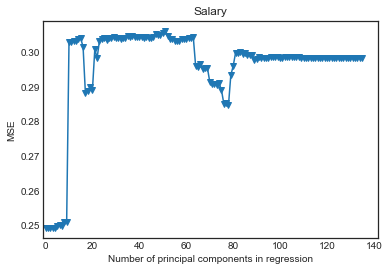

In [28]:
pca3 = PCA()
X_reduced_train = pca3.fit_transform(scale(X_train))
n = len(X_reduced_train)

kf_10 = KFold(n_splits= 10, shuffle=False, random_state=1)

mse = []
regr = LogisticRegression()

# Calculate MSE with only the intercept (no principal components in regression)
score = -1*cross_val_score(regr, np.ones((n,1)), y_train, cv=kf_10, scoring='neg_mean_squared_error').mean()    
mse.append(score)

# Calculate MSE using CV for the principle components, adding one component at the time.
for i in np.arange(1, 136):
    score = abs(cross_val_score(regr, X_reduced_train[:,:i], y_train, cv=kf_10, scoring='neg_mean_squared_error')).mean()
    mse.append(score)

plt.plot(np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1); 

[0.24928666884711181,
 0.24928666884711181,
 0.24928666884711181,
 0.24937265336989775,
 0.24911469980154002,
 0.24971659146104136,
 0.25006052955218494,
 0.24988856050661315,
 0.25100635930282983,
 0.25083439025725801,
 0.30311298011108428,
 0.30302699558829843,
 0.3032849491566561,
 0.3032849491566561,
 0.30397282533894332,
 0.30405880986172917,
 0.30165131722073157,
 0.28815167314633794,
 0.28883954932862516,
 0.28995734812484181,
 0.28926947194255465,
 0.30087738251865093,
 0.29846974188363823,
 0.30345684420522029,
 0.30388684081615736,
 0.30405880986172917,
 0.30354290272501377,
 0.30405880986172917,
 0.30423077890730099,
 0.30440274795287281,
 0.3043167634300869,
 0.3043167634300869,
 0.30397282533894332,
 0.30405880986172923,
 0.30423077890730099,
 0.3048326705668023,
 0.30448873247565872,
 0.30466070152123048,
 0.30457471699844463,
 0.30440274795287281,
 0.30448873247565872,
 0.30448873247565872,
 0.30423077890730099,
 0.30457471699844463,
 0.30414479438451514,
 0.304144794384

In [37]:
pca3 = PCA()
X_reduced_train = pca3.fit_transform(scale(X_train))
n = len(X_reduced_train)

X_reduced_test = pca3.transform(scale(X_test))[:,:80]

# Train regression model on training data 
reg_log = LogisticRegression()
model = reg_log.fit(X_reduced_train[:,:80], y_train)

# Prediction with test data
y_pred = reg_log.predict(X_reduced_test)
mean_squared_error(y_test, y_pred)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


0.26164519326065411

In [38]:
compare = pd.concat([pd.DataFrame(y_pred), y_test.reset_index(drop = True)], axis = 1)
compare.columns = ["pred", "test"]
correct = (compare["pred"] == compare["test"])
correct.value_counts()

True     2980
False    1056
dtype: int64

In [39]:
print(classification_report(compare["test"], compare["pred"]))

             precision    recall  f1-score   support

          0       0.79      0.90      0.84      3148
          1       0.32      0.16      0.21       888

avg / total       0.69      0.74      0.70      4036



In [40]:
y_port = y_test_in[y_pred == 1]

In [41]:
y_test_in.mean()

-0.14849392740473225

In [42]:
y_port.mean()

-0.0768552100217106

In [43]:
y_port.shape

(456,)

In [ ]:
pca4 = PCA()
X_reduced_perf = pca4.fit_transform(scale(X_train))
n = len(X_reduced_train)

X_reduced_test = pca3.transform(scale(X_test))[:,:14]

# Train regression model on training data 
reg_log = LogisticRegression()
model = reg_log.fit(X_reduced_train[:,:14], y_train)

# Prediction with test data
y_pred = reg_log.predict(X_reduced_test)
mean_squared_error(y_test, y_pred)

In [78]:
PCR_mod = pd.DataFrame(y_pred, columns = ['PCR'])

In [79]:
PCR_mod['PCR'].value_counts()

0    3580
1     456
Name: PCR, dtype: int64

In [80]:
PCR_mod.to_json('PCR_mod.json', orient='values')

PLS

In [27]:
def find_pls(num):
    
    n = len(X_train)
    kf_10 = KFold(n_splits= 10, shuffle=False, random_state=1)
    mse = []
    for i in np.arange(1, num):
        pls = PLSRegression(n_components=i)
        score = cross_val_score(pls, scale(X_train), y_train, \
                                cv=kf_10, scoring='neg_mean_squared_error').mean()
        mse.append(-score)
        
    return mse
    

In [ ]:
mse = find_pls(136)
n_pls = mse.index(min(mse))

In [62]:
pls = PLSRegression(n_components = n_pls + 1) #100
pls.fit(scale(X_train), y_train)
y_pred_pls = pls.predict(scale(X_test))
y_pred_pls = np.reshape(y_pred_pls, y_pred_pls.shape[0])
y_port = y_test_in[y_pred_pls >= .5]
y_port.mean()

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


-0.049330483432028456

In [63]:
y_test_in.mean()

-0.14849392740473225

In [68]:
print(classification_report(y_test, PLS_mod['PLS']))

             precision    recall  f1-score   support

          0       0.80      0.88      0.83      3148
          1       0.32      0.20      0.25       888

avg / total       0.69      0.73      0.71      4036



implementation

(-1, 142.75)

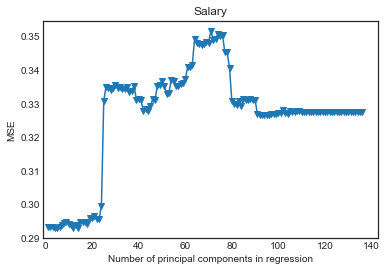

In [41]:
n = len(X_train)

# 10-fold CV, with shuffle
kf_10 = KFold(n_splits= 10, shuffle=False, random_state=1)

plt.plot(np.arange(1, 137), np.array(mse), '-v')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(xmin=-1) 

In [50]:
y_port.shape
y_port.mean()

-0.89845499696

In [81]:
PLS_mod = pd.DataFrame(y_pred_pls, columns = ['PLS'])

In [82]:
PLS_mod['PLS'] = (PLS_mod['PLS'] >= 0.5).astype(int)

In [83]:
PLS_mod['PLS'].value_counts()

0    3474
1     562
Name: PLS, dtype: int64

In [84]:
PLS_mod.to_json('PLS_mod.json', orient='values')